<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Compute-Overall-RAPM-from-Lineup-Stints" data-toc-modified-id="Compute-Overall-RAPM-from-Lineup-Stints-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Compute Overall RAPM from Lineup Stints</a></span><ul class="toc-item"><li><span><a href="#Calculate-and-Record-Matchup-Matrix-for-RAPM" data-toc-modified-id="Calculate-and-Record-Matchup-Matrix-for-RAPM-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Calculate and Record Matchup Matrix for RAPM</a></span></li><li><span><a href="#Calculate-Player-RAPM-from-Ridge-Regression-Coefficients" data-toc-modified-id="Calculate-Player-RAPM-from-Ridge-Regression-Coefficients-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Calculate Player RAPM from Ridge Regression Coefficients</a></span></li></ul></li><li><span><a href="#Compute-Offensive-and-Defensive-RAPM-from-Individual-Possessions" data-toc-modified-id="Compute-Offensive-and-Defensive-RAPM-from-Individual-Possessions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Compute Offensive and Defensive RAPM from Individual Possessions</a></span></li><li><span><a href="#Explore-Correlations-of-Advanced-Stats-with-RAPM" data-toc-modified-id="Explore-Correlations-of-Advanced-Stats-with-RAPM-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Explore Correlations of Advanced Stats with RAPM</a></span></li><li><span><a href="#Assessing-Lineups-from-Player-RAPMs" data-toc-modified-id="Assessing-Lineups-from-Player-RAPMs-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Assessing Lineups from Player RAPMs</a></span><ul class="toc-item"><li><span><a href="#Creating-Summed-RAPM-Variable-for-All-Lineups" data-toc-modified-id="Creating-Summed-RAPM-Variable-for-All-Lineups-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Creating Summed RAPM Variable for All Lineups</a></span></li><li><span><a href="#Exploring-RAPM-Based-Lineup-Impact" data-toc-modified-id="Exploring-RAPM-Based-Lineup-Impact-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Exploring RAPM-Based Lineup Impact</a></span></li></ul></li></ul></div>

In [1]:
import numpy as np
import time
import sys
import os
import pandas as pd
from functools import reduce
from operator import itemgetter
import itertools
import re
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import cm
import seaborn as sns
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from scipy import signal
from scipy.stats import gaussian_kde
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

In [2]:
# Set seaborn plot style
sns.set_style("whitegrid")

In [85]:
# Get array of unique player names from dataframe
def GetPlayerList(df):
    df_poss_players = []
    for index, poss in df.iterrows():
        df_poss_players += poss.ht_lineup.split(',')
        df_poss_players += poss.vt_lineup.split(',')
    return np.unique(df_poss_players)


# Create a (stints x players)-dimensional matrix containing
# coefficients of +1 for home team players, -1 for away team players in matchup.
# Also generates a stints-dimensional array containing the home team
# score margin resulting from that lineup matchup.
def GenerateMatchupMatrix(df, player_list):
    matchup_plus_minus = []
    rapm_matrix = np.zeros(shape=(len(df),len(player_list)), dtype=float)
    idx=0
    
    for index, stint in df.iterrows():
        if idx%100 == 0:
            sys.stdout.write("\rOn Stint %i..." % (idx+1))
            sys.stdout.flush()
        
        matchup_plus_minus.append(stint.ht_pm_ph)

        f_ht_p, f_allp_ind, f_htl_ind = np.intersect1d(player_list, stint.ht_lineup.split(','), return_indices=True)
        rapm_matrix[idx,f_allp_ind] = 1
        f_vt_p, f_allp_ind, f_vtl_ind = np.intersect1d(player_list, stint.vt_lineup.split(','), return_indices=True)
        rapm_matrix[idx,f_allp_ind] = -1

        idx += 1

    print('\n Finished!')
    return rapm_matrix, matchup_plus_minus


# Similar principle to the matchup matrix for lineup stints, 
# but breaks up play-by-play data into individual offensive 
# and defensive possessions. This is for separately computing
# the offensive and defensive components of RAPM.
def GeneratePossessionMatrix(df, player_list):
    poss_score = []
    orapm_matrix = np.zeros(shape=(len(df),len(player_list)), dtype=float)
    drapm_matrix = np.zeros(shape=(len(df),len(player_list)), dtype=float)
    idx=0
    
    for index, poss in df.iterrows():
        if idx%1000 == 0:
            sys.stdout.write("\rOn Possession %i..." % (idx+1))
            sys.stdout.flush()
        poss_score.append(poss.points_scored)

        f_ht_p, f_allp_ind, f_htl_ind = np.intersect1d(player_list, poss.ht_lineup.split(','), return_indices=True)
        if poss.ht_poss == 'OFF':
            orapm_matrix[idx,f_allp_ind] = 1
        elif poss.ht_poss == 'DEF':
            drapm_matrix[idx,f_allp_ind] = -1

        f_vt_p, f_allp_ind, f_vtl_ind = np.intersect1d(player_list, poss.vt_lineup.split(','), return_indices=True)
        if poss.vt_poss == 'OFF':
            orapm_matrix[idx,f_allp_ind] = 1
        elif poss.vt_poss == 'DEF':
            drapm_matrix[idx,f_allp_ind] = -1

        idx += 1

    print('\n Finished!')
    return orapm_matrix, drapm_matrix, poss_score


# Use the dataframe containing the RAPM values for each
# player to calculate the summed RAPM for each lineup in each stint
def CalculateLineupRAPM(df_player, df_stint):
    ht_lineup_RAPM = []
    vt_lineup_RAPM = []
    idx = 0

    for index, stint in df_stint.iterrows():
        if idx%100 == 0:
            sys.stdout.write("\rOn Stint %i..." % (idx+1))
            sys.stdout.flush()
        
        hl = stint.ht_lineup.split(',')
        vl = stint.vt_lineup.split(',')
        hRAPM = 0
        vRAPM = 0
        for hp in hl:
            if len(df_player[df_player.name == hp].RAPM) == 1:
                #print(df_player[df_player.name == hp].RAPM.values[0])
                hRAPM += df_player[df_player.name == hp].RAPM.values[0]
        for vp in vl:
            if len(df_player[df_player.name == vp].RAPM) == 1:
                #print(df_player[df_player.name == vp].RAPM.values[0])
                vRAPM += df_player[df_player.name == vp].RAPM.values[0]

        ht_lineup_RAPM.append(hRAPM)
        vt_lineup_RAPM.append(vRAPM)
        
        idx += 1

    df_stint['ht_lineup_RAPM'] = ht_lineup_RAPM
    df_stint['vt_lineup_RAPM'] = vt_lineup_RAPM

    return df_stint


# Get the perpendicular distance to a linear function
def PerpDistToLine(point_x, point_y, slope, intercept):
    return -((slope*point_x)-point_y+intercept)/np.sqrt((slope*slope)+1)


# Plot linear fit to scattered data along with the error bounds
def PlotLinearFit(x, y, ax):
    left, right = ax.get_xlim()
    ydown, yup = ax.get_ylim()

    par = np.polyfit(x, y, 1, full=True)
    slope=par[0][1]
    intercept=par[0][0]

    xl = [min(x), max(x)]
    yl = [slope*xx + intercept for xx in xl]
    yerr = [abs(slope*xx + intercept - yy)  for xx,yy in zip(x, y)]
    par = np.polyfit(x, yerr, 2, full=True)
    yerrUpper = [(xx*slope+intercept)+(par[0][0]*xx**2 + par[0][1]*xx + par[0][2]) for xx,yy in zip(x, y)]
    yerrLower = [(xx*slope+intercept)-(par[0][0]*xx**2 + par[0][1]*xx + par[0][2]) for xx,yy in zip(x, y)]

    ax.plot(xl, yl, 'r-', linewidth=3, label='Best Fit Line')
    pm_ph, yLow = zip(*sorted(zip(x, yerrLower)))
    ax.plot(pm_ph, yLow, 'r--', linewidth=3, label='Upper/Lower Error Bounds')
    pm_ph, yUpp = zip(*sorted(zip(x, yerrUpper)))
    ax.plot(pm_ph, yUpp, 'r--', linewidth=3)
    ax.legend(prop={'size':14})

    #variance = np.var(y)
    #residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(x, y)])
    #Rsqr = np.round(1-residuals/variance, decimals=2)
    #plt.text(.2*(np.max(x)-np.min(x))+np.min(x), .8*(np.max(y)-np.min(y))+np.min(y),'$R^2 = %0.2f$'% Rsqr, fontsize=20)

    ax.set_xlim(left, right)
    ax.set_ylim(ydown, yup)
    

# Load Data

In [4]:
# Load comprehensive dataset of player stats
dfp = pd.read_csv('../CompleteNBAPlayerStats.csv')
# Select only the full seasons collected to date (2017-2019, inclusive)
dfp = dfp[dfp.year.astype(int) != 2020]
# Take the mean of any rows of the same player name
dfp = dfp.groupby(['name'], as_index=False).mean()
# Grab the alphabetized list of unique player names
dfp_players = np.unique(dfp.name.values)
dfp


,name,year,GP,GS,height,weight,actual_draft_year,draft_round,draft_number,draft_year,...,2PR,3PR,FG_FREQ_RIM,FG_FREQ_MR_AND_PT,FG_FREQ_MR,FG_FREQ_CORNERS,FG_FREQ_AB,FG_FREQ_01DRIB,FG_FREQ_GT1DRIB,FG_FREQ_CANDS
0,Aaron Brooks,2016.5,67.000000,0.000000,72.0,161.0,2007.0,1.0,26.0,2008.0,...,0.589972,0.410028,0.240194,0.352428,0.188706,0.054405,0.054405,0.150916,0.323392,0.206841
1,Aaron Gordon,2017.5,73.500000,61.000000,81.0,220.0,2014.0,1.0,4.0,2015.0,...,0.679706,0.320294,0.380656,0.299191,0.187188,0.091812,0.091812,0.444849,0.277118,0.281265
2,Aaron Holiday,2019.0,50.000000,0.000000,73.0,185.0,2018.0,1.0,23.0,2019.0,...,0.515957,0.484043,0.210258,0.324944,0.191144,0.095572,0.095572,0.401402,0.611660,0.248487
3,Al Horford,2017.5,72.500000,72.500000,82.0,245.0,2007.0,1.0,3.0,2008.0,...,0.717827,0.282173,0.272703,0.445294,0.255362,0.045773,0.045773,0.552428,0.185475,0.440625
4,Al Jefferson,2017.5,51.000000,1.000000,82.0,265.0,2004.0,1.0,15.0,2005.0,...,0.990857,0.009143,0.331351,0.669310,0.336307,0.000000,0.000000,0.711395,0.112662,0.205500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,Zach Collins,2019.0,77.000000,0.000000,84.0,230.0,2017.0,1.0,10.0,2018.0,...,0.697183,0.302817,0.463122,0.231561,0.115780,0.038593,0.038593,0.868353,0.000000,0.328045
553,Zach LaVine,2017.5,54.000000,41.500000,77.0,183.0,2014.0,1.0,13.0,2015.0,...,0.651079,0.348921,0.350761,0.299421,0.223838,0.059883,0.059883,0.290171,0.425099,0.175050
554,Zach Randolph,2017.0,66.666667,38.333333,81.0,270.0,2001.0,1.0,19.0,NaN,...,0.892357,0.107643,0.336507,0.559642,0.316376,0.015352,0.015352,0.440996,0.186389,0.226121
555,Zaza Pachulia,2017.5,70.750000,49.750000,83.0,240.0,2003.0,2.0,42.0,NaN,...,0.990989,0.009011,0.648473,0.349407,0.197725,0.000000,0.000000,0.603990,0.052547,0.184120


In [5]:
# Grab dataset containing plus-minus data for each matchup stint over all games
df_stint = pd.read_csv('../NBA_Matchup_PlusMinus.csv', index_col=0)
df_stint


,year,game,ht_lineup,vt_lineup,ht_stint_pm,vt_stint_pm,ht_stint_poss,ht_pm_ph,vt_pm_ph
0,2017,1,"JR Smith,Kevin Love,Kyrie Irving,LeBron James,...","Carmelo Anthony,Courtney Lee,Derrick Rose,Joak...",2,-2,63,3.174603,-3.174603
1,2017,1,"JR Smith,Kyrie Irving,LeBron James,Richard Jef...","Brandon Jennings,Carmelo Anthony,Courtney Lee,...",1,-1,12,8.333333,-8.333333
2,2017,1,"Iman Shumpert,Kyrie Irving,LeBron James,Richar...","Brandon Jennings,Carmelo Anthony,Courtney Lee,...",0,0,11,0.000000,0.000000
3,2017,1,"Iman Shumpert,Kevin Love,Mike Dunleavy,Richard...","Brandon Jennings,Carmelo Anthony,Courtney Lee,...",4,-4,14,28.571429,-28.571429
4,2017,1,"Iman Shumpert,Kevin Love,Mike Dunleavy,Richard...","Brandon Jennings,Courtney Lee,Justin Holiday,K...",0,0,4,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
98072,2019,1230,"Jake Layman,Meyers Leonard,Gary Trent Jr.,Anfe...","Bogdan Bogdanovic,Corey Brewer,Frank Mason,Mar...",7,-7,17,41.176471,-41.176471
98073,2019,1230,"Anfernee Simons,Gary Trent Jr.,Jake Layman,Mey...","Bogdan Bogdanovic,Corey Brewer,Frank Mason,Mar...",5,-5,6,83.333333,-83.333333
98074,2019,1230,"Anfernee Simons,Gary Trent Jr.,Jake Layman,Mey...","Bogdan Bogdanovic,Corey Brewer,Frank Mason,Mar...",4,-4,18,22.222222,-22.222222
98075,2019,1230,"Anfernee Simons,Gary Trent Jr.,Jake Layman,Mey...","BJ Johnson,Corey Brewer,Frank Mason,Marvin Bag...",2,-2,7,28.571429,-28.571429


In [6]:
# Grab dataset containing plus-minus data for individual matchup possessions over all games
df_poss = pd.read_csv('../NBA_PBP_Data_Possessions.csv', index_col=0)
df_poss

,year,game,home_team,vis_team,Q,time_sec,ht_score,vt_score,ht_margin,vt_margin,...,vt_3PTA,ht_2PTM,vt_2PTM,ht_3PTM,vt_3PTM,ht_stint_pm,vt_stint_pm,ht_stint_poss,vt_stint_poss,points_scored
0,2017,1,CLE,NYK,1,20.0,0,2,-2,2,...,0,0,1,0,0,-2,2,2,2,2
1,2017,1,CLE,NYK,1,37.0,0,2,-2,2,...,0,0,1,0,0,-2,2,4,4,0
2,2017,1,CLE,NYK,1,45.0,0,4,-4,4,...,0,0,2,0,0,-4,4,7,7,2
3,2017,1,CLE,NYK,1,61.0,2,4,-2,2,...,0,1,2,0,0,-2,2,8,8,2
4,2017,1,CLE,NYK,1,62.0,2,4,-2,2,...,0,1,2,0,0,-2,2,9,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720766,2019,1230,POR,SAC,4,2832.0,135,131,4,-4,...,41,38,31,14,18,-1,1,35,35,2
720767,2019,1230,POR,SAC,4,2846.0,135,131,4,-4,...,42,38,31,14,18,-1,1,37,37,0
720768,2019,1230,POR,SAC,4,2859.0,136,131,5,-5,...,42,38,31,14,18,0,0,41,41,0
720769,2019,1230,POR,SAC,4,2869.0,136,131,5,-5,...,43,38,31,14,18,0,0,44,44,0


# Compute Overall RAPM from Lineup Stints

## Calculate and Record Matchup Matrix for RAPM

In [7]:
# Grab the list of unique players contained in the dataset of matchup stints
print('PBP matchup data contains', len(df_stint), 'stints.')
df_stint_players = GetPlayerList(df_stint)
print('Found', len(df_stint_players), 'unique players in the PBP matchup stint data.')
# Grab the overlapping player names and associated indices for the player and matchup datasets
f_players, f_dfp_ind, f_df_stint_ind = np.intersect1d(dfp_players, df_stint_players, return_indices=True)


PBP matchup data contains 98077 stints.
Found 742 unique players in the PBP matchup stint data.


In [8]:
# Create a matchup matrix from the dataset of lineup matchup stints
rapm_matrix, matchup_pm_ph = GenerateMatchupMatrix(df_stint, df_stint_players)

On Stint 98001...
 Finished!


In [69]:
# Create a dataframe from the RAPM matrix generated
df_rapm = pd.DataFrame(rapm_matrix, columns=df_stint_players)
#df_rapm.to_csv('NBA_RAPM_Data.csv')
df_rapm

,AJ Hammons,Aaron Brooks,Aaron Gordon,Aaron Harrison,Aaron Holiday,Aaron Jackson,Abdel Nader,Adreian Payne,Al Horford,Al Jefferson,...,Yante Maten,Yogi Ferrell,Yuta Watanabe,Zach Collins,Zach LaVine,Zach Lofton,Zach Randolph,Zaza Pachulia,Zhaire Smith,Zhou Qi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
98073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Calculate Player RAPM from Ridge Regression Coefficients

Ordinary Regression:

$Y = X\beta$

$X^T Y = X^T X\beta$

$\beta = (X^T X)^{-1} X^T Y$

Ridge Regression Technique:

$\beta = \left( X^T X + \lambda I \right)^{-1} X^T Y$

The perturbation $\lambda$ reduces variance at the expense of bias, causing "regularization" of outliers.

These $\beta$ coefficients are the relative player contribution scaled by a factor controlled by $\lambda$.

In [10]:
# Set the training data to the 3 full seasons of matchup 
# data prior to this year
x_train = rapm_matrix
y_train = matchup_pm_ph

In [11]:
# Test a variety of lambda parameters in the ridge regression
# in order to find a stable value. Also calculate the curves for the 
# asymptotic max/min RAPM players to show stability of our choice of lambda.
alphas = [1, 5, 10, 25, 50, 75, 100, 250, 500, 750, 1000, 1500]
curry = []
lbj = []
chriss = []
mccaw = []
max_arr = []
min_arr = []
rapm_alpha1 = []
rapm_alpha500 = []

for alph in alphas:
    ridge_reg = Ridge(alpha=alph)
    ridge_reg.fit(x_train, y_train)
    player_rapm = ridge_reg.coef_
    sorted_rapm_names = [x for _,x in sorted(zip(player_rapm, df_stint_players), reverse=True)]
    
    for i,player in enumerate(sorted_rapm_names):
        if player == 'Stephen Curry':
            curry.append(sorted(player_rapm, reverse=True)[i])
        elif player == 'LeBron James':
            lbj.append(sorted(player_rapm, reverse=True)[i])
        elif player == 'Marquese Chriss':
            chriss.append(sorted(player_rapm, reverse=True)[i])
        elif player == 'Patrick McCaw':
            mccaw.append(sorted(player_rapm, reverse=True)[i])
    
    min_arr.append(sorted(player_rapm, reverse=True)[-1])
    max_arr.append(sorted(player_rapm, reverse=True)[0])
    
    if alph == 1:
        rapm_alpha1 = player_rapm
    elif alph == 500:
        rapm_alpha500 = player_rapm
    

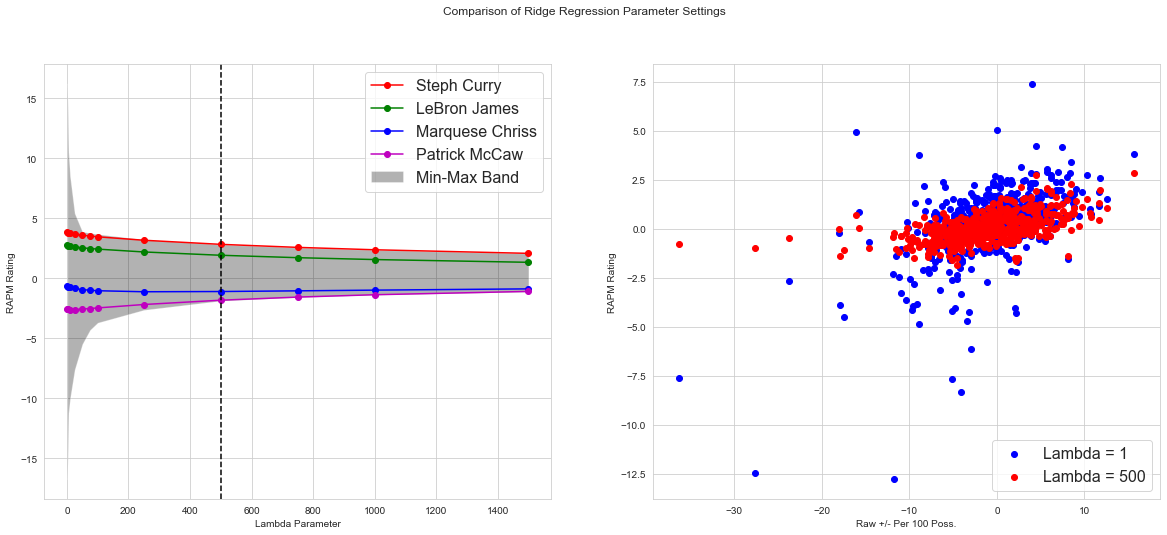

In [102]:
# Plot the lambda curves for the select players, along with
# a min/max band spanning the RAPM range.
# Also plot the RAPM/plus-minus distribution for 2 choices of lambda.

fig, ax = plt.subplots(1, 2, figsize=(20,8))
plt.suptitle('Comparison of Ridge Regression Parameter Settings')

plt.axes(ax[0])
plt.fill_between(alphas, min_arr, max_arr, facecolor='black', alpha=0.3, label='Min-Max Band')
plt.plot(alphas, curry, 'ro-', label='Steph Curry')
plt.plot(alphas, lbj, 'go-', label='LeBron James')
plt.plot(alphas, chriss, 'bo-', label='Marquese Chriss')
plt.plot(alphas, mccaw, 'mo-', label='Patrick McCaw')
plt.legend(loc='upper right', prop={'size': 16})
plt.axvline(x=500, linestyle='--', c='k')
plt.xlabel('Lambda Parameter')
plt.ylabel('RAPM Rating')

plt.axes(ax[1])
plt.scatter(dfp.PM_PH.values[f_dfp_ind], rapm_alpha1[f_df_stint_ind], c='b', label='Lambda = 1')
plt.scatter(dfp.PM_PH.values[f_dfp_ind], rapm_alpha500[f_df_stint_ind], c='r', label='Lambda = 500')
plt.xlabel('Raw +/- Per 100 Poss.')
plt.ylabel('RAPM Rating')
plt.legend(loc='lower right', prop={'size': 16})


In [13]:
# Make our choice of lambda and perform final RAPM regression
ridge_reg = Ridge(alpha=500)
ridge_reg.fit(x_train, y_train)
# Grab the regression coefficients, which give scaled player RAPM values
player_rapm = ridge_reg.coef_

In [14]:
# Add RAPM values to the player dataframe (for players actually contained therein)
dfp.loc[f_dfp_ind, 'RAPM'] = player_rapm[f_df_stint_ind]
dfp['RAPM'] = pd.to_numeric(dfp['RAPM'])

# Print the offensive, defensive, and net ratings of the top 20 players
# along with their overall RAPM rating (sorted)
print('Top 20 Players in RAPM:')
print(dfp[['name', 'OFFRTG', 'DEFRTG', 'NETRTG', 'RAPM']].sort_values('RAPM', ascending=False).head(20))


Top 20 Players in RAPM:
                      name      OFFRTG      DEFRTG  NETRTG      RAPM
487          Stephen Curry  119.425000  104.000000  15.450  2.828147
98          Damian Lillard  111.975000  107.650000   4.325  2.729867
326             Kyle Lowry  113.550000  105.450000   8.100  2.273383
287           Jrue Holiday  108.475000  105.850000   2.650  2.118920
3               Al Horford  109.100000  103.475000   5.600  2.088527
406           Nikola Jokic  112.275000  107.025000   5.225  2.039710
87              Chris Paul  114.650000  102.900000  11.725  1.975109
426            Paul George  109.075000  104.650000   4.450  1.926775
338           LeBron James  113.500000  107.700000   5.825  1.918405
222           James Harden  114.250000  108.075000   6.150  1.828844
457            Rudy Gobert  110.300000  102.000000   8.300  1.818914
310             Kevin Love  112.775000  109.175000   3.600  1.639936
458      Russell Westbrook  112.525000  105.650000   6.850  1.637617
183  Giann

# Compute Offensive and Defensive RAPM from Individual Possessions

In [15]:
# Get list of unique players in our possession dataset and find 
# the overlapping players between this data and the player dataset
print('PBP matchup data contains', len(df_poss), 'possessions.')
df_poss_players = GetPlayerList(df_poss)
print('Found', len(df_poss_players), 'unique players in the PBP possession data.')
f_players, f_dfp_ind, f_df_poss_ind = np.intersect1d(dfp_players, df_poss_players, return_indices=True)

PBP matchup data contains 720771 possessions.
Found 743 unique players in the PBP possession data.


In [16]:
# Using our possession dataset, which is similar to our matchup stint dataset
# but broken up into individual offensive and defensive possessions,
# generate separate offensive and defensive RAPM matrices
orapm_matrix, drapm_matrix, off_score = GeneratePossessionMatrix(df_poss, df_poss_players)

On Possession 720001...
 Finished!


In [98]:
# Using the same value of lambda as for overall RAPM rating,
# perform a ridge regression on the offensive and defensive 
# matchup matrices separately.

x_train = orapm_matrix
y_train = off_score
off_ridge_reg = Ridge(500)
off_ridge_reg.fit(x_train, y_train)
player_orapm = off_ridge_reg.coef_

x_train = drapm_matrix
y_train = off_score
def_ridge_reg = Ridge(500)
def_ridge_reg.fit(x_train, y_train)
player_drapm = def_ridge_reg.coef_


In [99]:
# Add ORAPM and DRAPM values to the player dataframe (for players actually contained therein)
dfp.loc[f_dfp_ind, 'ORAPM'] = player_orapm[f_df_poss_ind]
dfp.loc[f_dfp_ind, 'DRAPM'] = player_drapm[f_df_poss_ind]
dfp['ORAPM'] = pd.to_numeric(dfp['ORAPM'])
dfp['DRAPM'] = pd.to_numeric(dfp['DRAPM'])

# Print the top 20 players in ORAPM and DRAPM
print('\nTop 20 Players in ORAPM:')
print(dfp[['name', 'RAPM', 'ORAPM', 'DRAPM']].sort_values('ORAPM', ascending=False).head(20))

print('\nTop 20 Players in DRAPM:')
print(dfp[['name', 'RAPM', 'ORAPM', 'DRAPM']].sort_values('DRAPM', ascending=False).head(20))


Top 20 Players in ORAPM:
                   name      RAPM     ORAPM     DRAPM
487       Stephen Curry  2.828147  0.103358 -0.003281
338        LeBron James  1.918405  0.068767 -0.005433
406        Nikola Jokic  2.039710  0.067723 -0.016861
556        Zhaire Smith  0.013470  0.067386 -0.030156
302        Kemba Walker  1.504968  0.066056 -0.011404
326          Kyle Lowry  2.273383  0.060379  0.026501
87           Chris Paul  1.975109  0.057289  0.014393
479          Shawn Long  0.285700  0.056194  0.009106
298  Karl-Anthony Towns  1.550925  0.055777 -0.019920
436           Raul Neto  1.531591  0.053609  0.066216
272     Jordan Crawford -0.044417  0.053605 -0.019165
52         Bradley Beal  1.452114  0.051724 -0.010424
309       Kevin Huerter  1.021572  0.051110 -0.007518
98       Damian Lillard  2.729867  0.047964  0.006590
3            Al Horford  2.088527  0.046380 -0.001306
222        James Harden  1.828844  0.042645 -0.030753
310          Kevin Love  1.639936  0.042600  0.005976
45

In [19]:
# Write the extended player dataframe to a CSV file
dfp.to_csv('../CompleteNBAPlayerStats_RAPM.csv')

# Explore Correlations of Advanced Stats with RAPM

In [20]:
# Load the new RAPM dataframe if necessary
#dfp = pd.read_csv('../CompleteNBAPlayerStats_RAPM.csv', index_col=0)

(28, -0.5)

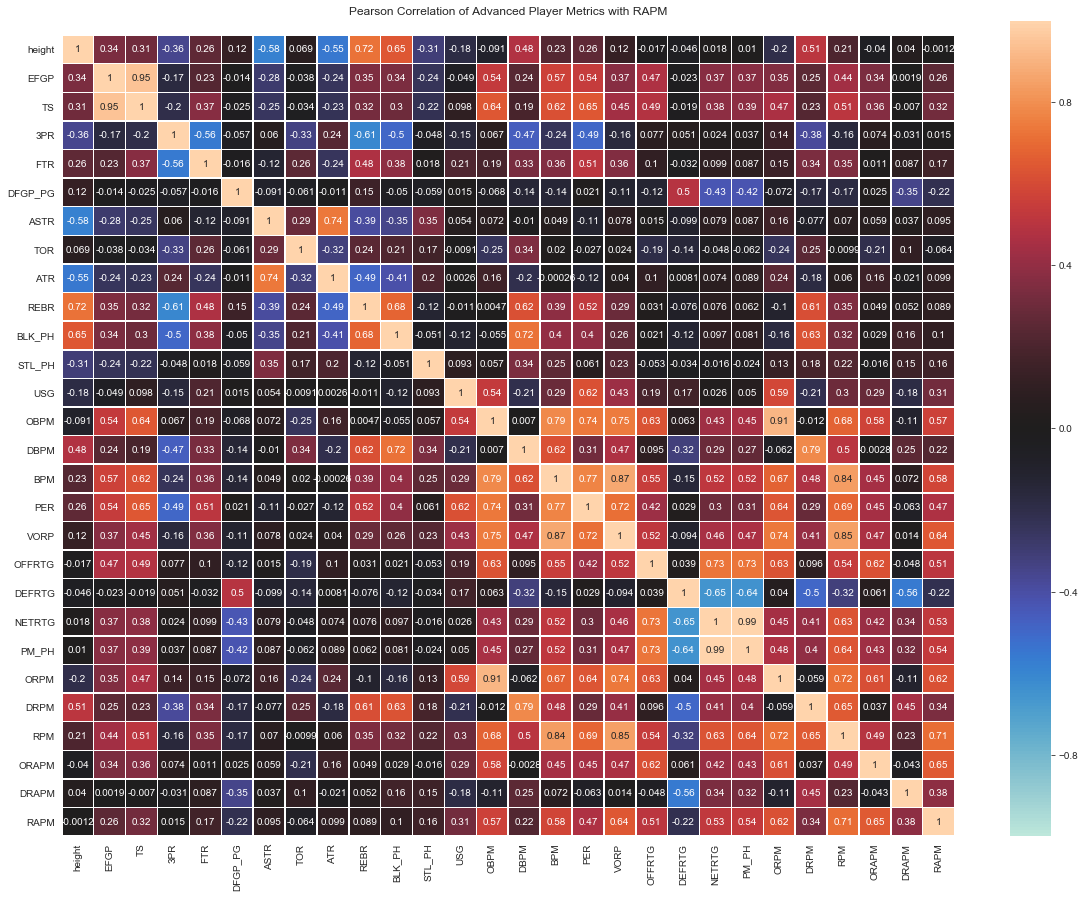

In [100]:
# Plot a Pearson correlation matrix for all relevant statistics to investigate 
# correlations and compare RAPM ratings with other advanced stats
fig, ax = plt.subplots(figsize=(20, 15))
cols_to_inc = ['height', 'EFGP', 'TS', '3PR', 'FTR', 'DFGP_PG', 'ASTR', 'TOR', 'ATR', 'REBR', 'BLK_PH', 'STL_PH', 'USG', 'OBPM', 'DBPM', 'BPM', 'PER', 'VORP', 'OFFRTG', 'DEFRTG', 'NETRTG', 'PM_PH', 'ORPM', 'DRPM', 'RPM', 'ORAPM', 'DRAPM', 'RAPM']
features = dfp[cols_to_inc]
pc = features.corr(method='pearson')
sns.heatmap(pc, annot=True, xticklabels=pc.columns, 
            yticklabels=pc.columns, ax=ax, linewidths=.5, 
            vmin = -1, vmax=1, center=0)
plt.title("Pearson Correlation of Advanced Player Metrics with RAPM")
ax.set_ylim(len(pc), -0.5)


Observations:
* Advanced metrics like BPM (Box Plus-Minus), PER, and RPM (Real Plus-Minus) are actually negatively correlated with the fraction of shots that are 3-pointers, while Offensive Rating and ORAPM are uncorrelated. It appears that this is mostly due to the huge negative correlation with the defensive component (i.e. big men who don't shoot 3-pointers).
* DBPM and DRPM (defensive metrics) are highly correlated with blocks and steals (box score stats), even though such stats appear to be completely uncorrelated with opponent field goal percentage. Defensive Rating and DRAPM are more correlated with opponent FGP and much less correlated with blocks and steals.
* Perhaps the biggest discrepancy is that all the advanced stats aside from raw +/-, Off/Def Rating and Off/Def RAPM are moderately-to-highly correlated with rebounding rate. The RAPM model naturally takes into account a player's intangibles and impact, but does not agree with the significance of rebounding.
* Overall, it looks as though box-score based advanced stats favor big men, or players who fill the stat sheet with blocks and rebounds. Another indication of this is that advanced defensive stats imply that better defenders tend to turn the ball over more, which is more true with large centers but not as true for good defensive guards/forwards.
* RAPM provides a "correction" to raw player +/- without arbitrarily weighting box score stats, since matchups are won partially based on underlying intangibles.

(-0.15, 0.15)

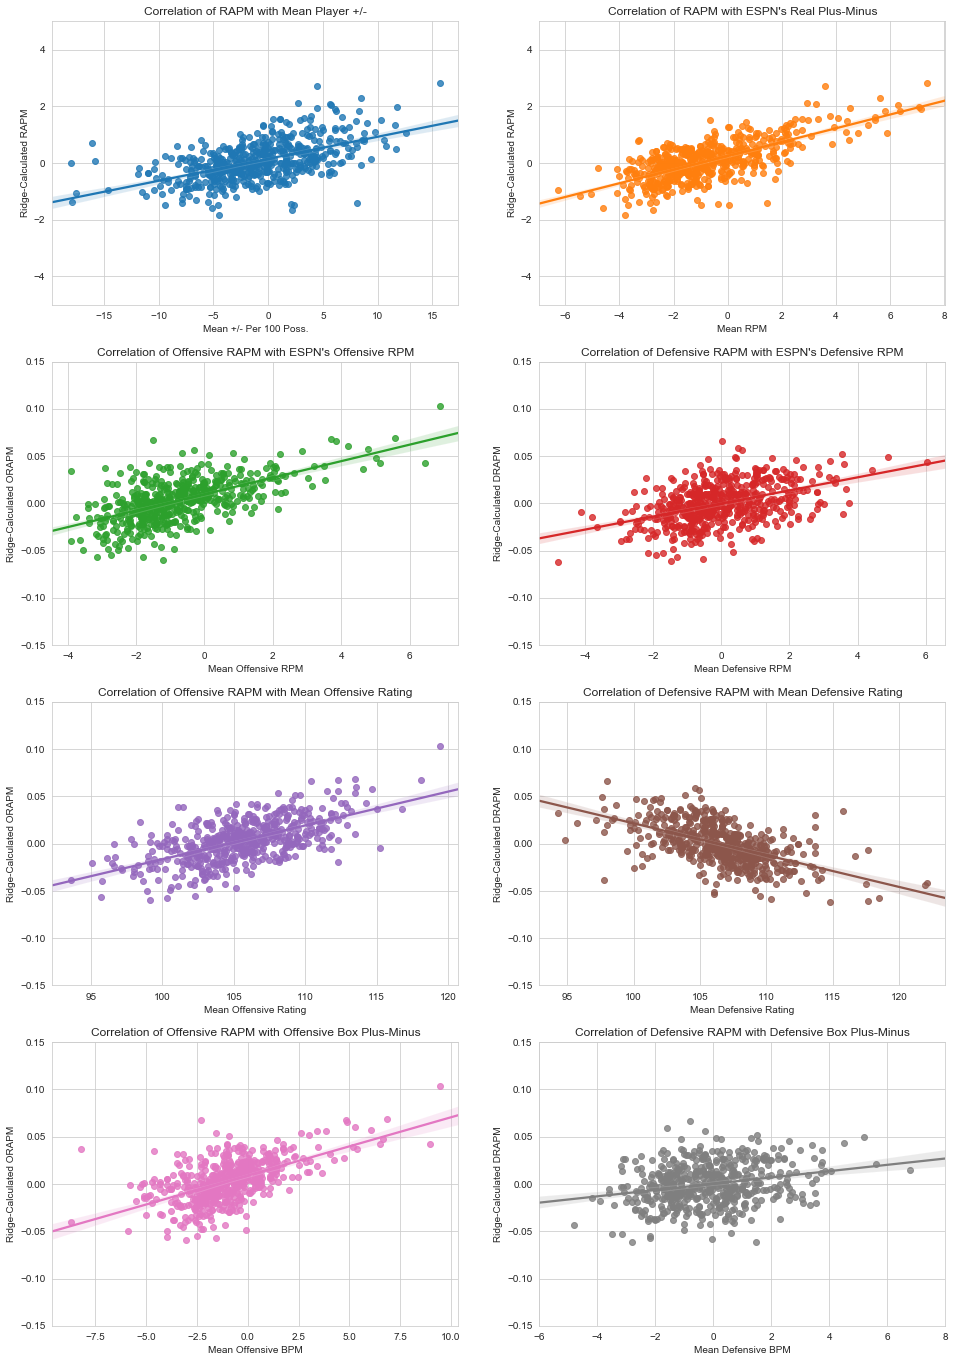

In [101]:
# Make regression plots for all players with an RAPM rating,
# comparing RAPM, ORAPM, and DRAPM ratings with various other
# advanced stats such as raw off/def ratings, ESPN's real-plus minus (RPM),
# and advanced box plus-minus (BPM).

fig, ax = plt.subplots(4, 2, figsize=(16,24))

sns.regplot(x="PM_PH", y="RAPM", data=dfp[dfp.PM_PH>-20], ax=ax[0,0], scatter=True)
ax[0,0].set(xlabel='Mean +/- Per 100 Poss.', ylabel='Ridge-Calculated RAPM', title='Correlation of RAPM with Mean Player +/-')
ax[0,0].set_ylim(-5, 5)

sns.regplot(x="RPM", y="RAPM", data=dfp, ax=ax[0,1])
ax[0,1].set(xlabel='Mean RPM', ylabel='Ridge-Calculated RAPM', title="Correlation of RAPM with ESPN's Real Plus-Minus")
ax[0,1].set_ylim(-5, 5)

sns.regplot(x="ORPM", y="ORAPM", data=dfp, ax=ax[1,0])
ax[1,0].set(xlabel='Mean Offensive RPM', ylabel='Ridge-Calculated ORAPM', title="Correlation of Offensive RAPM with ESPN's Offensive RPM")
ax[1,0].set_ylim(-0.15, 0.15)

sns.regplot(x="DRPM", y="DRAPM", data=dfp, ax=ax[1,1])
ax[1,1].set(xlabel='Mean Defensive RPM', ylabel='Ridge-Calculated DRAPM', title="Correlation of Defensive RAPM with ESPN's Defensive RPM")
ax[1,1].set_ylim(-0.15, 0.15)

sns.regplot(x="OFFRTG", y="ORAPM", data=dfp[dfp.OFFRTG > 90], ax=ax[2,0])
ax[2,0].set(xlabel='Mean Offensive Rating', ylabel='Ridge-Calculated ORAPM', title='Correlation of Offensive RAPM with Mean Offensive Rating')
ax[2,0].set_ylim(-0.15, 0.15)

sns.regplot(x="DEFRTG", y="DRAPM", data=dfp[dfp.DEFRTG>80], ax=ax[2,1])
ax[2,1].set(xlabel='Mean Defensive Rating', ylabel='Ridge-Calculated DRAPM', title='Correlation of Defensive RAPM with Mean Defensive Rating')
ax[2,1].set_ylim(-0.15, 0.15)

sns.regplot(x="OBPM", y="ORAPM", data=dfp, ax=ax[3,0])
ax[3,0].set(xlabel='Mean Offensive BPM', ylabel='Ridge-Calculated ORAPM', title='Correlation of Offensive RAPM with Offensive Box Plus-Minus')
ax[3,0].set_ylim(-0.15, 0.15)

sns.regplot(x="DBPM", y="DRAPM", data=dfp, ax=ax[3,1])
ax[3,1].set(xlabel='Mean Defensive BPM', ylabel='Ridge-Calculated DRAPM', title='Correlation of Defensive RAPM with Defensive Box Plus-Minus')
ax[3,1].set_xlim(-6, 8)
ax[3,1].set_ylim(-0.15, 0.15)


In [117]:
# For all players with a valid RAPM (and more than 20 MPG), 
# do a linear fit and calculate the deviation of the player 
# from this fit line to assess their "underratedness" 
# of their impact relative to raw plus-minus

dfp_rapm = dfp[dfp.RAPM.isnull() == False]

par = np.polyfit(dfp_rapm.PM_PH.values, dfp_rapm.RAPM.values, 1, full=True)
slope=par[0][1]
intercept=par[0][0]

#dists = PerpDistToLine(dfp_rapm.PM_PH.values, dfp_rapm.RAPM.values, slope, intercept)
diff = dfp_rapm.RAPM.values - (slope*dfp_rapm.PM_PH.values + intercept)
dfp_rapm['RAPM_PM_DIFF'] = dists

print('RAPM, +/- Differential (Underratedness of Player Relative to Mean):')
print(dfp_rapm[dfp_rapm.GP>40][['name', 'RAPM', 'PM_PH', 'RAPM_PM_DIFF']].sort_values('RAPM_PM_DIFF', ascending=False))


RAPM, +/- Differential (Underratedness of Player Relative to Mean):
                   name      RAPM      PM_PH  RAPM_PM_DIFF
454         Roy Hibbert  0.012209 -18.000000      2.558937
98       Damian Lillard  2.729867   4.450000      1.985199
125       Deandre Ayton  0.601857  -8.300000      1.732673
287        Jrue Holiday  2.118920   2.750000      1.627790
77   Chandler Hutchison  0.799879  -6.100000      1.608878
..                  ...       ...        ...           ...
423   Patrick Patterson -0.343428   6.033333     -1.285568
468        Semi Ojeleye -0.416405   5.600000     -1.294796
26     Andrew Nicholson -1.463084   2.100000     -1.821726
44      Bismack Biyombo -1.479448   2.400000     -1.881514
217      Jamal Crawford -1.652060   2.150000     -2.015962

[433 rows x 4 columns]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


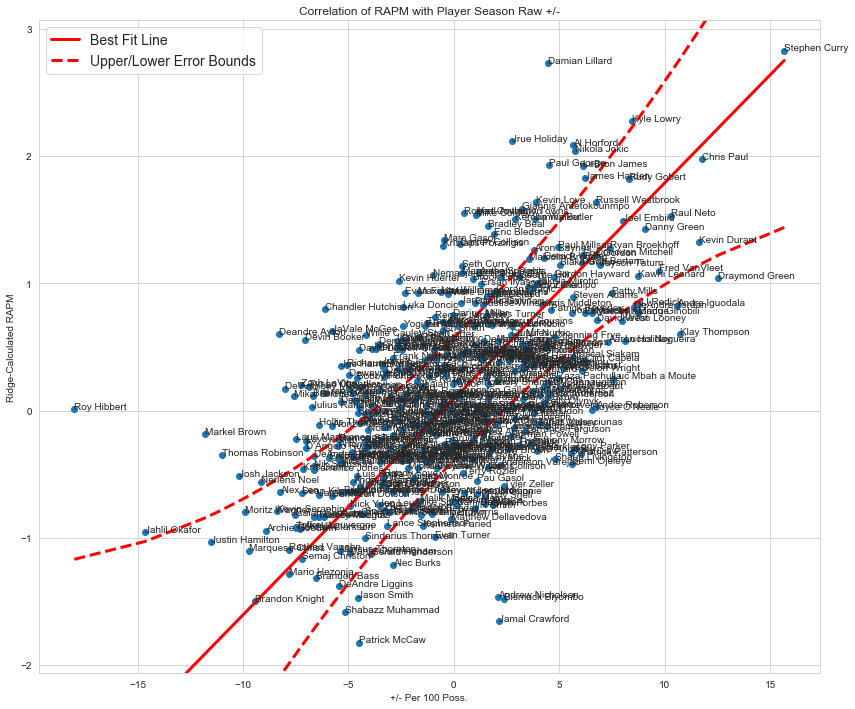

In [118]:
# Plot a linear fit of player RAPM relative to raw plus-minus
# (along with error bounds) for all players with an RAPM rating

fig, ax = plt.subplots(figsize=(14,12))

plt.title('Correlation of RAPM with Player Season Raw +/-')
plt.xlabel('+/- Per 100 Poss.')
plt.ylabel('Ridge-Calculated RAPM')
ax.scatter(dfp_rapm[dfp_rapm.GP>40].PM_PH, dfp_rapm[dfp_rapm.GP>40].RAPM)
for i, txt in enumerate(dfp_rapm[dfp_rapm.GP>40].name):
    ax.annotate(txt, (dfp_rapm[dfp_rapm.GP>40].PM_PH.values[i], dfp_rapm[dfp_rapm.GP>40].RAPM.values[i]))

PlotLinearFit(dfp_rapm[dfp_rapm.GP>40].PM_PH.values, dfp_rapm[dfp_rapm.GP>40].RAPM.values, ax)
    

# Assessing Lineups from Player RAPMs

## Creating Summed RAPM Variable for All Lineups

In [60]:
# Using the dataframe containing player RAPM, go through
# the lineup matchup dataset and calculate the summed RAPM
# for all lineups
df_stint = CalculateLineupRAPM(dfp, df_stint)
df_stint

On Stint 98001...

,year,game,ht_lineup,vt_lineup,ht_stint_pm,vt_stint_pm,ht_stint_poss,ht_pm_ph,vt_pm_ph,ht_lineup_RAPM,vt_lineup_RAPM
0,2017,1,"JR Smith,Kevin Love,Kyrie Irving,LeBron James,...","Carmelo Anthony,Courtney Lee,Derrick Rose,Joak...",2,-2,63,3.174603,-3.174603,4.025767,1.858554
1,2017,1,"JR Smith,Kyrie Irving,LeBron James,Richard Jef...","Brandon Jennings,Carmelo Anthony,Courtney Lee,...",1,-1,12,8.333333,-8.333333,2.396186,0.851647
2,2017,1,"Iman Shumpert,Kyrie Irving,LeBron James,Richar...","Brandon Jennings,Carmelo Anthony,Courtney Lee,...",0,0,11,0.000000,0.000000,3.023024,-1.280987
3,2017,1,"Iman Shumpert,Kevin Love,Mike Dunleavy,Richard...","Brandon Jennings,Carmelo Anthony,Courtney Lee,...",4,-4,14,28.571429,-28.571429,1.448421,-1.280987
4,2017,1,"Iman Shumpert,Kevin Love,Mike Dunleavy,Richard...","Brandon Jennings,Courtney Lee,Justin Holiday,K...",0,0,4,0.000000,0.000000,1.448421,-1.714436
...,...,...,...,...,...,...,...,...,...,...,...
98072,2019,1230,"Jake Layman,Meyers Leonard,Gary Trent Jr.,Anfe...","Bogdan Bogdanovic,Corey Brewer,Frank Mason,Mar...",7,-7,17,41.176471,-41.176471,-0.277196,-0.992394
98073,2019,1230,"Anfernee Simons,Gary Trent Jr.,Jake Layman,Mey...","Bogdan Bogdanovic,Corey Brewer,Frank Mason,Mar...",5,-5,6,83.333333,-83.333333,-0.675702,-0.992394
98074,2019,1230,"Anfernee Simons,Gary Trent Jr.,Jake Layman,Mey...","Bogdan Bogdanovic,Corey Brewer,Frank Mason,Mar...",4,-4,18,22.222222,-22.222222,-0.675702,0.547926
98075,2019,1230,"Anfernee Simons,Gary Trent Jr.,Jake Layman,Mey...","BJ Johnson,Corey Brewer,Frank Mason,Marvin Bag...",2,-2,7,28.571429,-28.571429,-0.675702,0.567464


In [63]:
# Write the new dataframe to CSV file
df_stint.to_csv('../NBA_Matchup_PlusMinus_byLineup.csv')

## Exploring RAPM-Based Lineup Impact

(-70, 70)

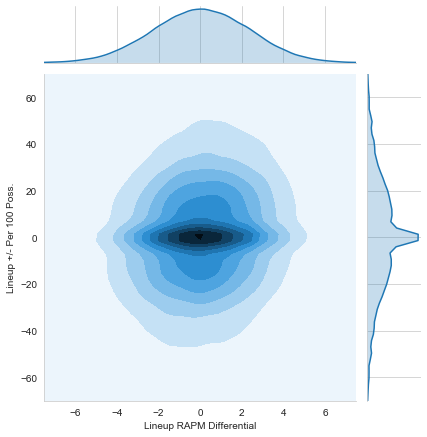

In [106]:
# Create a contour plot of the lineup +/- (per matchup) 
# relative to the differential of summed RAPMs between the 
# two lineups in the matchup
dfmu = df_stint.groupby(['ht_lineup', 'vt_lineup'], as_index=False).mean()
#g = sns.jointplot(x=df_stint.ht_lineup_RAPM-df_stint.vt_lineup_RAPM, y=df_stint.ht_pm_ph, kind="kde")
g = sns.jointplot(x=dfmu.ht_lineup_RAPM-dfmu.vt_lineup_RAPM, y=dfmu.ht_pm_ph, kind="kde")
g.set_axis_labels("Lineup RAPM Differential", "Lineup +/- Per 100 Poss.")
g.ax_marg_x.set_xlim(-7.5, 7.5)
g.ax_marg_y.set_ylim(-70, 70)